# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучите общую информацию. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'ceiling_height'}>],
       [<AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>],
       [<AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>,
        <AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>],
       [<AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>,
        <AxesSubplot:title={'center':'days_exposition'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'floor'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

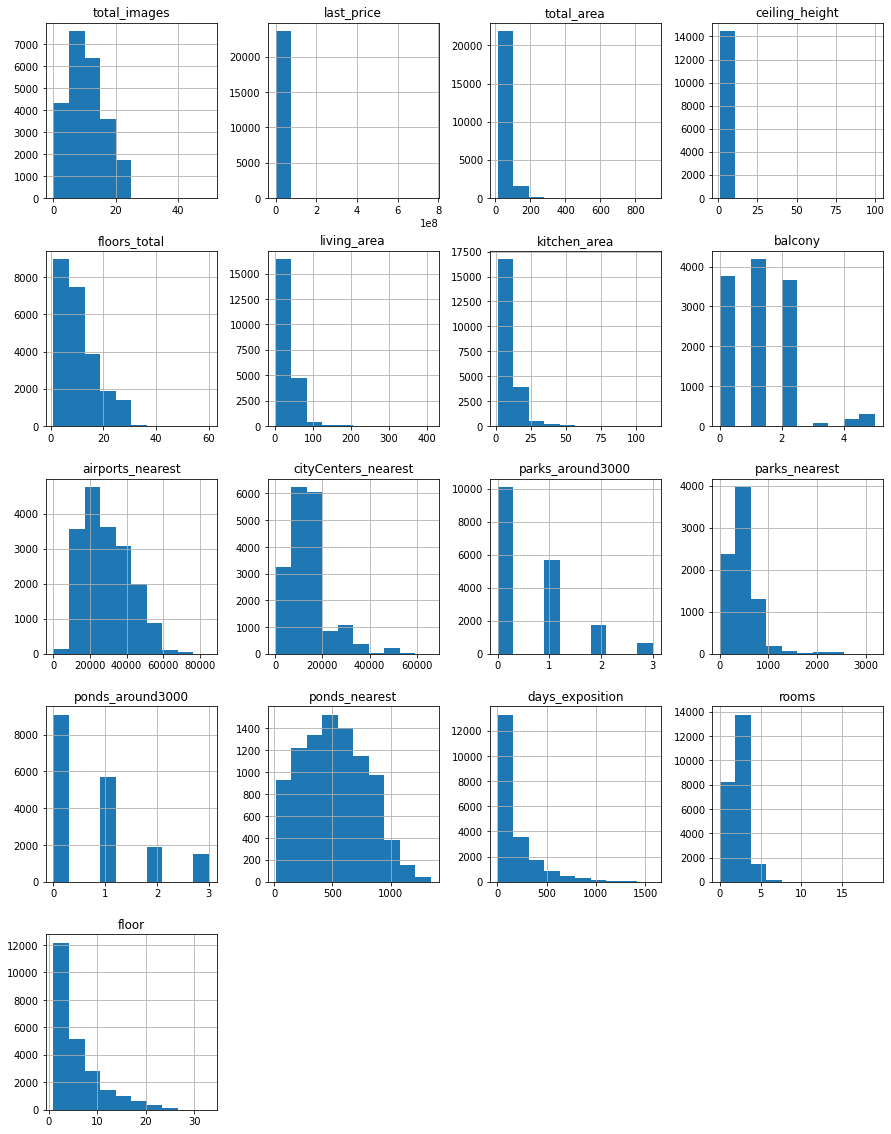

In [1]:
import datetime
import seaborn as sns

import pandas as pd
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t' , decimal='.')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv')
data.info()
print(data)
print(data.dtypes)
intdata=data.loc[:,['total_images','last_price', 'total_area','ceiling_height','floors_total','living_area','kitchen_area','balcony','airports_nearest','cityCenters_nearest', 'parks_around3000','parks_nearest', 'ponds_around3000','ponds_nearest','days_exposition','rooms', 'floor']]
intdata.hist(figsize=(15, 20))





Вывод:  при первичном рассмотрении данных можно отметить что в датафрейме присутсвуют пропущенные значения.
Датафрейм состоит из 23699 наблюдений и 22 столбцов.

### Предобработка данных

In [2]:
1.
data.isna().sum()
#print(data.loc[:,'is_apartment']!= True)
data['is_apartment'] = data['is_apartment'].fillna(False)  #судя по всему, в данном случае столбец 'is_apartment' не заполнен по помещениям, которые не является апартаментами. Нередко ответ "нет, отсутствует данное значение" люди не заполняют
#print(data['is_apartment'].isna().sum())
#print(data.head(20))
data['balcony'] = data['balcony'].fillna(0)  #судя по всему, в данном случае столбец 'balcony' не заполнен по помещениям, которые не имеют балконов. Нередко ответ "нет, отсутствует данное значение" люди не заполняют
#print(data['balcony'].isna().sum())
data['locality_name'].fillna('', inplace=True)  #видимо, забыли указать эти данные, рассматривать данные по помещениям, которые неизвестно где, не имеет смысла. С учетом того, что таких строк всего 49 (небольшой процент от наших исходных данных), можем убрать эти строки без потери результативности нашего анализа.
data['locality_name'].dropna(inplace=True)
#print(data['locality_name'].isna().sum())
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median()) #заполнили медианой пропуски
#print(data['ceiling_height'].isna().sum())

Вывод: 
1. столбец 'is_apartment' не заполнен по помещениям, которые не является апартаментами. Нередко ответ "нет, отсутствует данное значение" люди не заполняют;
2. столбец 'balcony' не заполнен по помещениям, которые не имеют балконов. Нередко ответ "нет, отсутствует данное значение" люди не заполняют;
3. столбец 'locality_name' не заполнен, видимо, по случайности, таких пропусков мало, мы их удалили;
4. столбец 'ceiling_height' не заполнен, видимо, по случайности, заменили пропуски на медиану, так как данные в этом столбце находятся в небольшом диапазоне;
5. что касается отсутствующих значений в других столбцах (видимо, их забыли указать), то их мы не заполняем, пока не уточним данные у владельцев помещений, так как и размер кухни, и жилая площадь, и количество этажей могут быть любыми даже в рамках одного района, поэтому медианные и средние значения могут быть очень далеки от реальности. У меня в районе, например, и сталинки, и хрущевки, и панельки. Все значения по ним ооочень разные.
airports_nearest, cityCenters_nearest,parks_around3000,parks_nearest,  ponds_around3000, ponds_nearest мы тоже сами заполнить не можем, не зная района и адреса         

In [3]:
2.
data['first_day_exposition'] = pd.to_datetime(
   data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'  # даты должны иметь специальный формат для дат, также это необходимо для сравнения с другими датами
)
#print(data)
data['last_price'] = data['last_price'].astype('int')  #преобразовали в int, так как по сути это числа, с которыми теперь можно проводить математические операции, также так удобнее сравнивать значения разных помещений по этому столбцу между собой.
print(data.dtypes)
#print(data.duplicated().sum())  #явных дубликатов нет
#print(data.head(40))

total_images                     int64
last_price                       int64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object


Вывод: 
 1.мы привели стобцы к другим форматам, которые больше подходят по смыслу, а также для того, чтобы данные можно было использовать для дальнейших вычислений;
 2.явных дубликатов нет.

In [4]:
3.
def rename_locality(name):
    if 'ё' in name:
        return name.replace('ё', 'е')
    return name

data['locality_name'] = data['locality_name'].apply(rename_locality)

data['locality_name'] = (data['locality_name'].str 
                       .replace('поселок городского типа ', '').str
                       .replace('городской поселок ', '').str
                       .replace('коттеджный поселок ', '').str
                       .replace('поселок станции ', '').str
                       .replace('поселок при железнодорожной станции ', '').str
                       .replace('поселок ', '').str  
                       .replace('деревня ', '').str
                       .replace('садовое товарищество ', '').str
                       .replace('село ', ''))
                     
print(data['locality_name'].unique())

['Санкт-Петербург' 'Шушары' 'Янино-1' 'Парголово' 'Мурино' 'Ломоносов'
 'Сертолово' 'Петергоф' 'Пушкин' 'Кудрово' 'Коммунар' 'Колпино'
 'Красный Бор' 'Гатчина' 'Федоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'Новое Девяткино' 'Металлострой' 'Лебяжье' 'Сиверский' 'Молодцово'
 'Кузьмоловский' 'Новая Ропша' 'Павловск' 'Пикколово' 'Всеволожск'
 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк' 'Куттузи' 'Аннино'
 'Ефимовский' 'Плодовое' 'Заклинье' 'Торковичи' 'Первомайское'
 'Красное Село' 'Понтонный' 'Сясьстрой' 'Старая' 'Лесколово' 'Новый Свет'
 'Сланцы' 'Путилово' 'Ивангород' 'Шлиссельбург' 'Никольское' 'Зеленогорск'
 'Сосновый Бор' 'Оржицы' 'Кальтино' 'Романовка' 'Бугры' 'Рощино' 'Кириши'
 'Луга' 'Волосово' 'Отрадное' 'Павлово' 'Оредеж' 'Копорье' 'Молодежное'
 'Тихвин' 'Победа' 'Нурма' 'Синявино' 'Тосно' 'Стрельна' 'Бокситогорск'
 'Александровская' 'Лопухинка' 'Пикалево' 'Терволово' 'Советский'
 'Подпорожье' 'Петровское' 'Токсово' 'Сельцо' 'Вырица' 'Кипень' 'Келози'
 'Вартемяги' 'Тельмана' '

Вывод:
    1. неявные дубликаты есть в столбце 'locality_name';
    2. мы их устранили с помощью функции.

In [5]:
4.
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height']<10, data['ceiling_height']/10) #исправлены некорректные значения. видимо, забыли поставить запятую в некоторых местах
#print(data[data['total_images'] > 100])
data = data.drop(data[data.last_price > 100000000].index)
#print(data[data['last_price'] > 100000000])
data = data.drop(data[data.last_price < 500000].index)
#print(data[data['last_price'] < 500000])
#print(data[data['last_price'] < 100000]) #были данные со стоимостью помещений меньше 100 000 р. Это нереалистично, поэтому удалила
data = data.drop(data[data.total_area > 350].index)
#print(data[data['total_area'] > 350])
#print(data[data['total_area'] <10])
#print(data[data['rooms'] <1])  #судя по метражам, похоже на квартиры-студии,где комнаты и кухни обьеденены, вероятно, поэтому написано, что комнат "0" 
data = data.drop(data[data.rooms > 7].index)
#print(data[data['rooms'] >7]) 
data['rooms'] = data['rooms'].where(data['rooms']>=1, 1)
#print(data[data['rooms'] <1])
#print(data[data['floors_total'] <1])
#print(data[data['floors_total'] >100])
#print(data[data['living_area'] > 2000])
#print(data[data['floor'] <1])
#print(data[data['floor'] >100])
data.shape[0] 
print(23596/23699)

0.9956538250559095


Вывод:
  1. В данных по высоте потолков забыли поставить запятую в некоторых местах,данные изменены на подходящие по смыслу;
  2. в данных по цене есть редкие помещения со слишком низкой и слишком высокой ценой, удалили;
  3. в данных по комнатам есть значения "0", вероятно, из-за того, что комната объединена с кухней в этих квартирах, поменяли на "1";
  4. в данных по комнатам есть редкие значения с количеством комнат более 7, мы их удалили;
  5. в данных по общей площади есть редкие значения с площадью помещений больше 350 м, мы их удалили;
  6. мы отбросили приемлемое количество редких значений (около 0,4%, что менее 10 процентов от изначальных данных), так как датафрейм изначально состоял из 23699 строчки, теперь - из 23596.

### Посчитаем и добавим в таблицу новые столбцы

In [6]:
data['price_for_metr']=data['last_price']/data['total_area'] 
import numpy as np
data['price_for_metr'] = np.round(data['price_for_metr'])
#print(data['price_for_metr'])
data['date_publication'] = data['first_day_exposition']
data['publication_day'] = data['date_publication'].dt.weekday
data['publication_month'] = data['date_publication'].dt.month
data['publication_year'] = data['date_publication'].dt.year
def floor_type (row):
    floor = row['floor']
    floors_total = row['floors_total']
    
    if floor == 1:
        return 'Первый'
    if floor == floors_total:
        return 'Последный'
    else:
        return 'Другой'
data['floor_type'] = data.apply(floor_type, axis =1 ) # Добавляем признак "тип этажа" 
print(data['floor_type'])
data.insert(3, "cityCenters_nearest_km",data['cityCenters_nearest']/1000 )
data['cityCenters_nearest_km'] = np.round(data['cityCenters_nearest_km'])
print(data['cityCenters_nearest_km'])


0        Другой
1        Первый
2        Другой
3        Другой
4        Другой
          ...  
23694    Другой
23695    Другой
23696    Первый
23697    Другой
23698    Первый
Name: floor_type, Length: 23596, dtype: object
0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
23694     4.0
23695     NaN
23696     NaN
23697    10.0
23698     NaN
Name: cityCenters_nearest_km, Length: 23596, dtype: float64


Итог:
новые столбцы с заданными значениями добавлены.

### Проведем исследовательский анализ данных

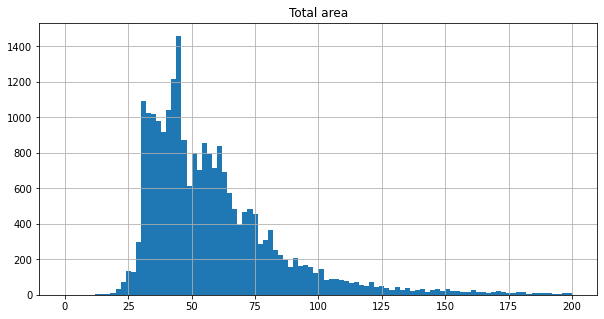

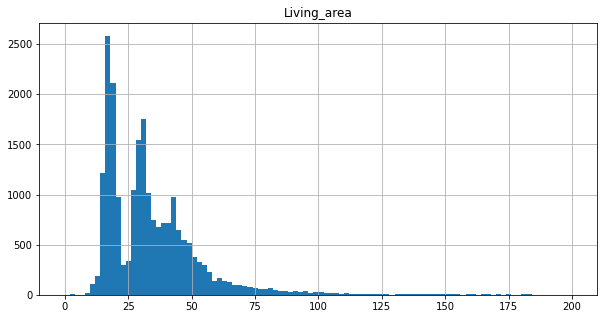

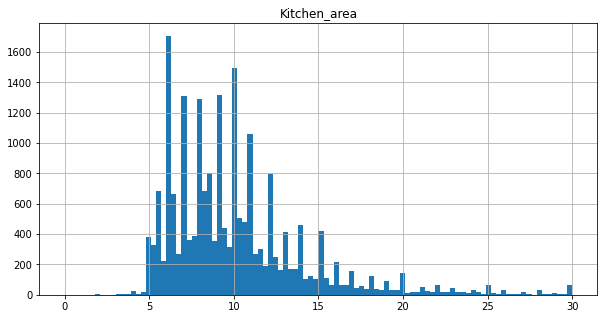

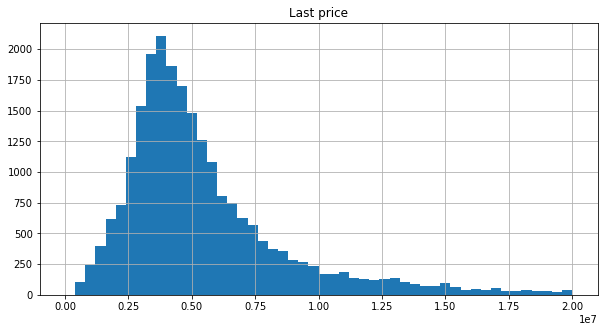

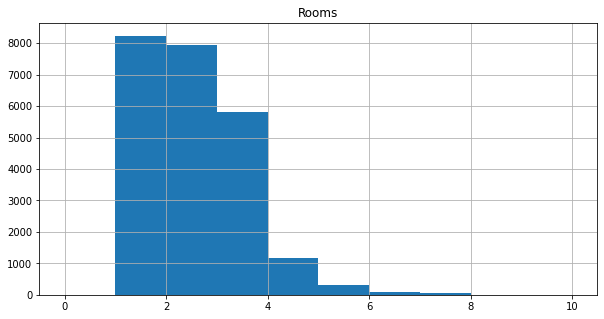

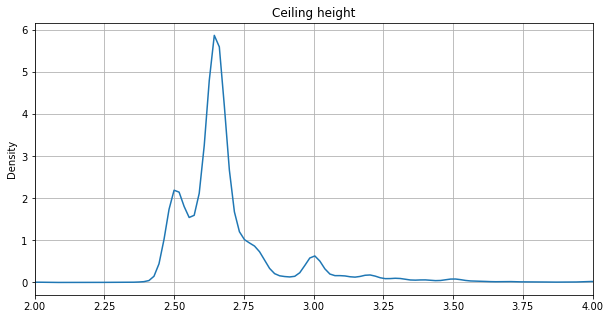

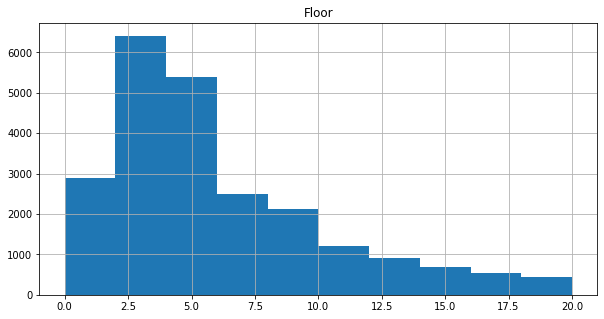

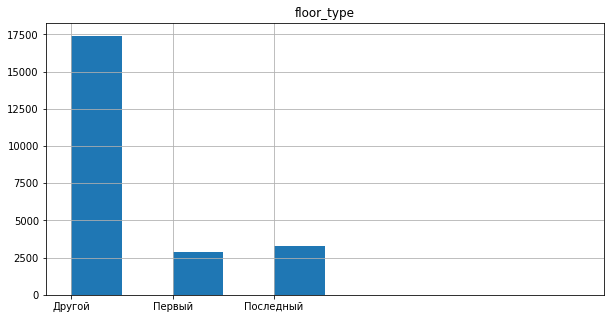

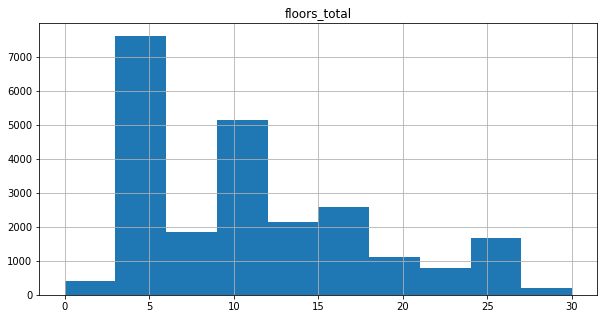

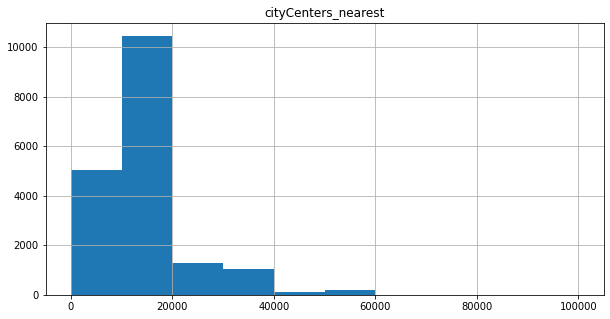

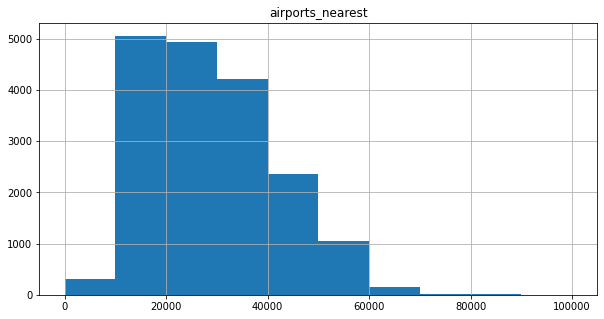

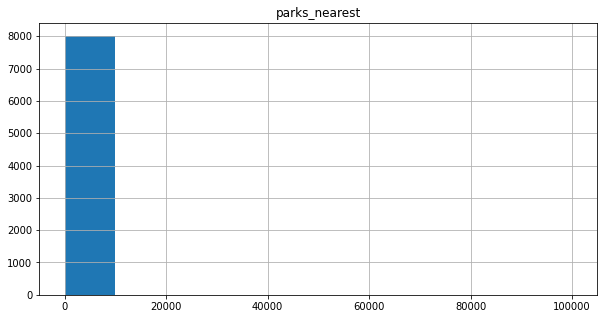

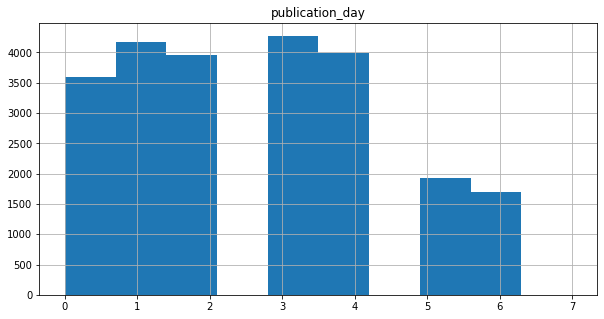

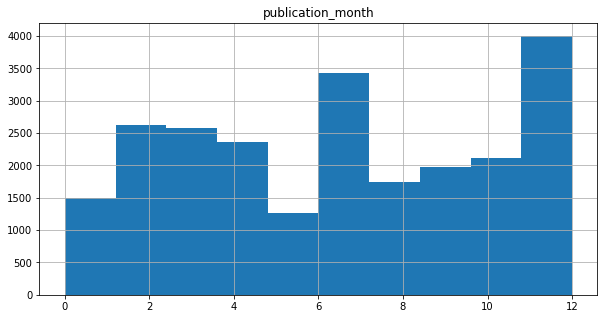

In [7]:
1.
import matplotlib.pyplot as plt
data['total_area'].hist(bins = 100, range = (0,200), figsize = (10,5) ,label= 'total_area')
plt.title('Total area')
plt.show()


data['living_area'].hist(bins = 100, range = (0,200), figsize = (10,5) ,label= 'living_area')
plt.title('Living_area')
plt.show()

data['kitchen_area'].hist(bins = 100, range = (0,30), figsize = (10,5) ,label= 'kitchen_area')
plt.title('Kitchen_area')
plt.show()

data['last_price'].hist(bins = 50, range = (0,20000000), figsize = (10,5) ,label = 'last_price', grid =True)
plt.title('Last price')
plt.show()


data['rooms'].hist(bins = 10, range = (0,10), figsize = (10,5) ,label = 'rooms', grid = True)
plt.title('Rooms')
plt.show()


data['ceiling_height'].plot(kind = 'kde',   figsize = (10,5) ,label = 'ceiling_height', xlim = (2,4), grid=True)
plt.title('Ceiling height')
plt.show()

data['floor'].hist(bins = 10, range = (0,20), figsize = (10,5) ,label = 'floor', grid = True)
plt.title('Floor')
plt.show()


data['floor_type'].hist(bins = 10, range = (0,5), figsize = (10,5) ,label = 'floor_type', grid = True)
plt.title('floor_type')
plt.show()


data['floors_total'].hist(bins = 10, range = (0,30), figsize = (10,5) ,label = 'floors_total', grid = True)
plt.title('floors_total')
plt.show()


data['cityCenters_nearest'].hist(bins = 10, range = (0,100000), figsize = (10,5) ,label = 'cityCenters_nearest', grid = True)
plt.title('cityCenters_nearest')
plt.show()


data['airports_nearest'].hist(bins = 10, range = (0,100000), figsize = (10,5) ,label = 'airports_nearest', grid = True)
plt.title('airports_nearest')
plt.show()


data['parks_nearest'].hist(bins = 10, range = (0,100000), figsize = (10,5) ,label = 'parks_nearest', grid = True)
plt.title('parks_nearest')
plt.show()


data['publication_day'].hist(bins = 10, range = (0,7), figsize = (10,5) ,label = 'publication_day', grid = True)
plt.title('publication_day')
plt.show()


data['publication_month'].hist(bins = 10, range = (0,12), figsize = (10,5) ,label = 'publication_month', grid = True)
plt.title('publication_month')
plt.show()


Вывод: 
1. большая часть квартир общей площадью от 30 до 47 метров,помещения с общей площадью более 100 метров представлены в минимальном количестве;
2. большая часть квартир жилой площадью около 30 или около 20 метров, помещения с жилой площадью более 50 метров представлены в минимальном количестве;
3. в основном размер кухни 6-12м;
4. дешевле 1 млн. и дороже 12 млн. помещений очень мало, наиболее хорошо представлена ценовая категория 3-6 млн.руб.;
5. больше 5 комнат помещений минимум, хорошо представлены 1,2,3-х комнатные квартиры;
6. чаще всего высота потолков составляет 2,5 метра, реже-2,75 м, еще реже - 3 м, квартир с другой высотой потолков минимальное количество;
7. в основном помещения находятся на 2-6 этажах, выше 12 этажа - редкость;
8. в основном помещения находятся на не первом и не последнем этаже;
9. наиболее широко представлены 3-6-этажные, затем 9-12-этажные дома, выше 27 этажей и ниже 3 домов практически нет;
10. большая часть помещений расположена на расстоянии 10-20 км от центра города;
11. большая часть помещений расположена на расстоянии 10-40 км от аэропорта;
12. все помещения расположены на расстоянии до 10 км от парка;
13. большая часть объявлений о продаже появляется в первой половине недели, в воскресенье обьявления не появляются;
14. большая часть объявлений о продаже появляется в декабре, чуть меньше - в июне, в остальном появление обьявлений плюс-минус равномерно.






count    20436.000000
mean       180.438246
std        219.208980
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64
95.0


<AxesSubplot:>

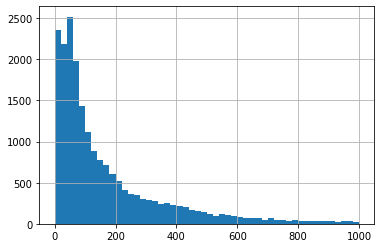

In [8]:
2.
print(data['days_exposition'].describe())
print(data['days_exposition'].median())
data['days_exposition'].hist(bins =  50 , range = (0,1000))


Вывод:
1.обычно продажа квартиры занимает 95 дней;
2.можно считать что продажа прошла быстро, если она совершена быстрее,чем за 45 дней или прошла необычно долго, если была продана позднее 231 дня со дня публикации.


0        2
1        1
2        2
3        2
4        2
        ..
23694    2
23695    2
23696    1
23697    2
23698    1
Name: floor_type_figures, Length: 23596, dtype: object


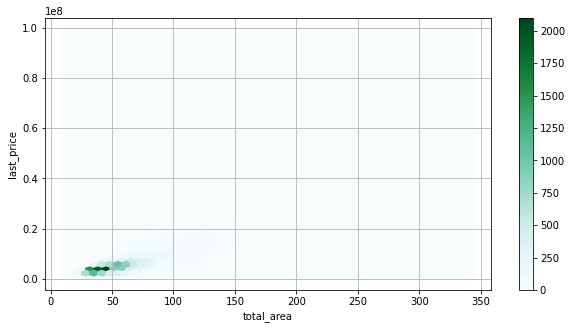

Коэффициент корреляции last_price и total_area :0.76


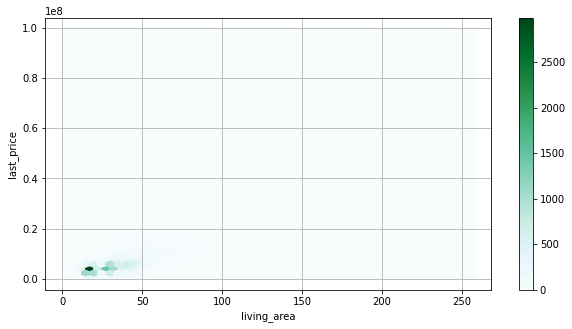

Коэффициент корреляции last_price и living_area :0.66


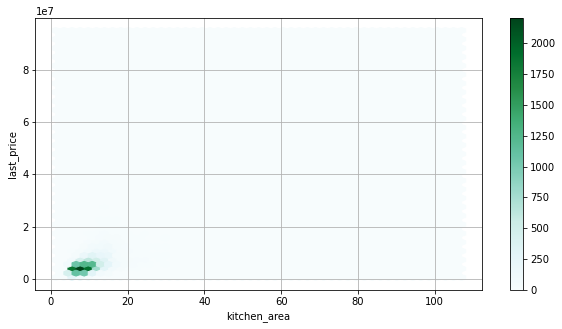

Коэффициент корреляции last_price и kitchen_area :0.58


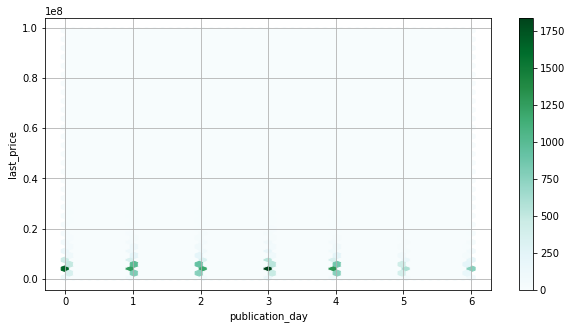

Коэффициент корреляции last_price и publication_day :-0.01


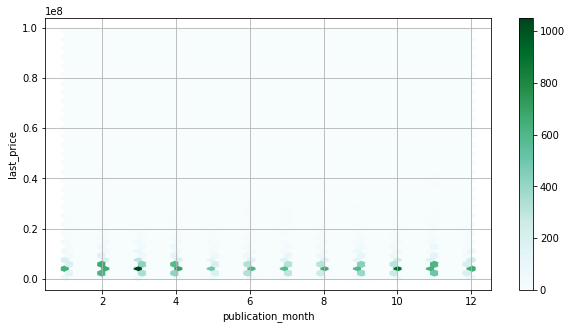

Коэффициент корреляции last_price и publication_month :0.01


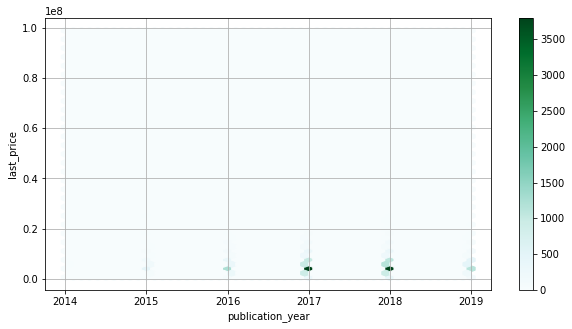

Коэффициент корреляции last_price и publication_year :-0.06


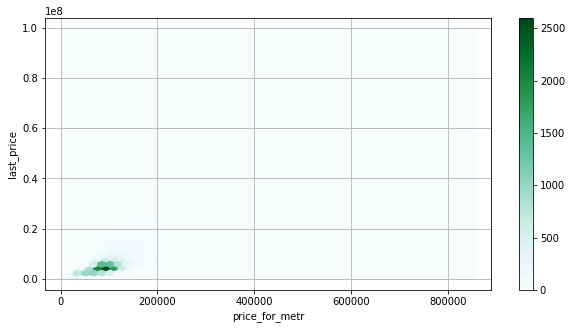

Коэффициент корреляции last_price и price_for_metr :0.73


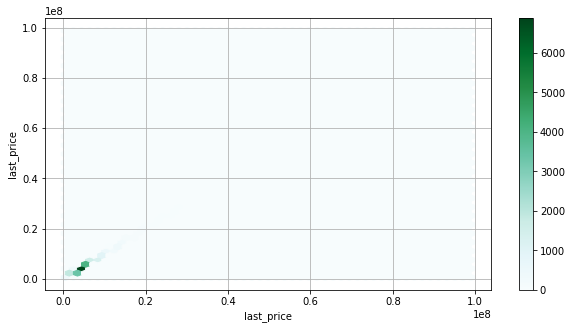

Коэффициент корреляции last_price и last_price :1.0


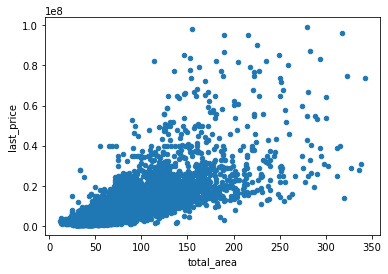

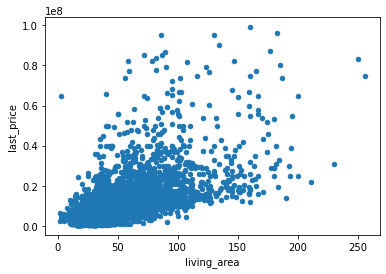

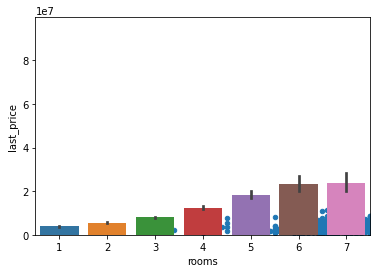

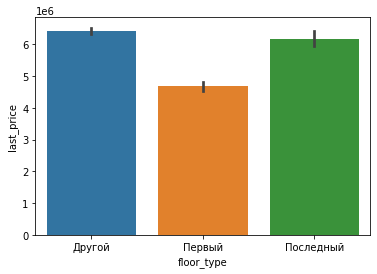

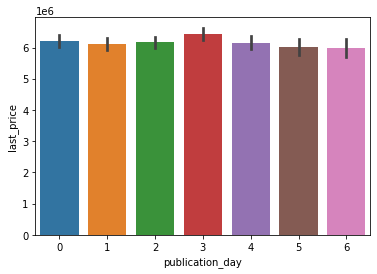

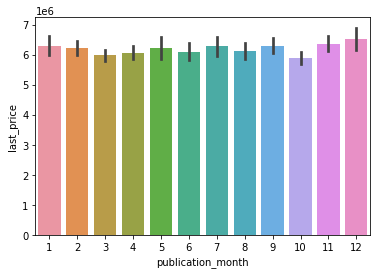

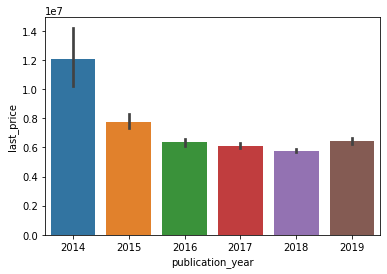

6178545.014536362


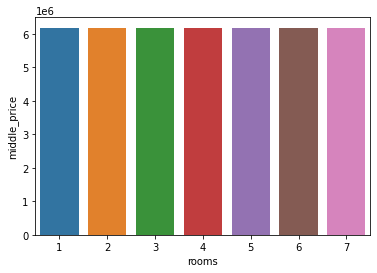

In [9]:
3.
data['publication_day']=data['publication_day'].astype('float').astype('int')
data['publication_month']=data['publication_month'].astype('float').astype('int')
data['publication_year']=data['publication_year'].astype('float').astype('int')
data['price_for_metr']=data['price_for_metr'].astype('float').astype('int')
data['cityCenters_nearest_km']=data['cityCenters_nearest_km'].astype('float')
#print(data.dtypes)
data['floor_type_figures']=data['floor_type']
data['floor_type_figures']=(data['floor_type_figures'].str
                       .replace('Первый', '1').str
                       .replace('Последний', '3').str
                       .replace('Другой', '2'))
print(data['floor_type_figures'])
#data['floor_type_figures']=data['floor_type_figures'].astype('str').astype('float').astype('int') по непонятным мне причинам не срабатывает (у меня ведь цифры стоят реально в этом столбце, а он мне выдает ошибку, как будто я столбец со словами пытаюсь сделать int), соответственно не могу проверить зависимость цены от типа этажа.

        
corelation_data = data[['total_area', 'living_area', 'kitchen_area' , 'publication_day','publication_month','publication_year','price_for_metr','last_price']]

#График  и значения корреляции для каждого возможного фактора:
for column in corelation_data:
    corelation_data.plot(x =  column , y = 'last_price', kind = 'hexbin', gridsize = 50, figsize = (10,5), sharex = False, grid= True)
    corelation = corelation_data['last_price'].corr(corelation_data[column]).round(2)
    plt.show()
    print('Коэффициент корреляции last_price и {} :{}'.format(column, corelation))

corelation_data.plot(x =  'total_area' , y = 'last_price', kind='scatter')
corelation_data.plot(x =  'living_area' , y = 'last_price', kind='scatter')
corelation_data.plot(x =  'kitchen_area', y = 'last_price', kind='scatter')

sns.barplot(x =  'rooms', y = 'last_price', data=data)
plt.show()
sns.barplot(x =  'floor_type', y = 'last_price', data=data)
plt.show()
sns.barplot(x =  'publication_day', y = 'last_price', data=corelation_data)
plt.show()
sns.barplot(x =  'publication_month', y = 'last_price', data=corelation_data)
plt.show()
sns.barplot(x =  'publication_year', y = 'last_price', data=corelation_data)
plt.show()

print(data['last_price'].mean())
data['middle_price'] =data['last_price'].mean()

sns.barplot(x =  'rooms', y = 'middle_price', data=data)
plt.show()


Вывод:
1.коэффициент корреляции общей площади и цены за помещение - 0,76, жилой площади и цены за помещение - 0,66, площади кухни и цены за помещение - 0,58, цены за метр и цены за помещение - 0,73 что свидетельствует о значительной связи между этими значениями; 
2.день и месяц публикации почти не влияет на цену квартир;
3.год публикации может влиять на цену помещения, в 2014 году цены на помещения значительнь выше, чем в 2015-2019 годах, в 2015 цены не так значительно, но все же заметно выше, чем в 2016-2019 годах;
4. помещения на первом этаже значительно дешевле квартир на других этажах, помещения на последнем этаж незначительно, но заметно дешевле квартир на других этажах кроме первого;
5. цена заметно зависит от количества комнат (цена увеличивается с увеличением количества комнат, но между 6 и 7 комнатами уже нет большой разницы в цене).


In [10]:
4.
count_by_location = data['locality_name'].value_counts().head(10).index
average_price = (data.query('locality_name in @count_by_location').pivot_table(index='locality_name', values='price_for_metr', aggfunc='mean'))
print(average_price)


                 price_for_metr
locality_name                  
Всеволожск         68654.474874
Выборг             58141.919831
Гатчина            68746.110749
Колпино            75333.287834
Кудрово            95324.957627
Мурино             86087.508475
Парголово          90175.886850
Пушкин            103130.852861
Санкт-Петербург   113599.989766
Шушары             78677.379545


Вывод: 
самый дорогой квадратный метр в Санкт-Петербурге - 114856 руб., самый дешевый - в Выборге - 58142 руб.

<AxesSubplot:xlabel='cityCenters_nearest_km'>

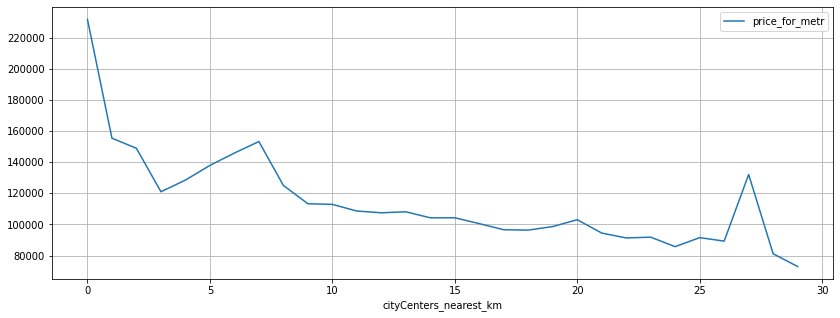

In [11]:
5. 
Peter_data = data.query('locality_name == "Санкт-Петербург"').reset_index(drop=True)
Peter_data.pivot_table(index='cityCenters_nearest_km', values='price_for_metr').plot(grid=True, figsize=(14, 5))


Вывод: самые дорогие квартиры в центре Санкт-Петербурга. Просматривается тенденция уменьшения цены по мере удаленности от центра

### Общий вывод

Была изучена информация по продаваемым помешениям в различных регионах России.

Отмечено, что наиболее широко в выборке представлены следующие помещения:
- 1,2,3-х комнатные квартиры;
- общей площадью от 30 до 47 метров;
- площадь кухни 6-12 м;
- этажность домов 3-6 и 9-12 этажей;
- цена 3-6 млн. руб.;
- высота потолков 2,5 и 2,75 м.

На основании проведенного анализа можно сделать следующие выводы:
1. Большая часть квартир в рассмотренных населенных пунктах России соответствует вышеперечисленным особенностям;
2. Все рассмотренные населенные пункты имеют парки, при этом в крупных населенных пунктах их много в расчете на квадратный километр (все квартиры находятся в пределах 10 км от парков);
3. Большая часть объявлений о продаже появляется в первой половине недели, в воскресенье обьявления не появляются;
4. Большая часть объявлений о продаже появляется в декабре, чуть меньше - в июне, в остальном появление обьявлений плюс-минус равномерно;
5. Обычно продажи квартиры занимает 95 дней;
6. Цена помещения зависит от цены квадратного метра, от размера общей и жилой площади, а также площади кухни,от количества комнат, года публикации объявления, удаленности от центра города, в каком именно населенном пункте находится помещение, а также от того, не является ли этаж первым или последним;
7. Самый дорогой квадратный метр в Санкт-Петербурге - 114856 руб., самый дешевый - в Выборге - 58142 руб.;
8. Самые дорогие квартиры в центре Санкт-Петербурга. Просматривается тенденция уменьшения цены по мере удаленности от центра.

